## Imports

Import packages, set options for displaying and for generating reproducable results (random seed)

In [2]:
%matplotlib inline
import xgboost
import sklearn
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt 

import matplotlib as mpl

import datetime
import numpy as np
import pandas as pd
import time
from scipy import stats

from collections import Counter
from IPython.display import display, HTML
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score,log_loss, accuracy_score, make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
import warnings
import sys
print(sys.version)
print("Numpy:",np.__version__)
print("Pandas:",pd.__version__)
print("XGBoost:",xgboost.__version__)
print("sklearn:",sklearn.__version__)
print("matplotlib:",matplotlib.__version__)

warnings.filterwarnings("ignore", category=DeprecationWarning) #sklearn throws too much deprecationwarnings
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 1)
np.set_printoptions(precision=3)
pd.set_option('display.float_format', lambda x: '%.1f' % x)
FONT_SIZE=16
params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (8, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}
plt.rcParams.update(params)


#rc={'axes.labelsize': FONT_SIZE, 'font.size': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 'axes.titlesize': FONT_SIZE,'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
#plt.rcParams.update(**rc)



seed = 1234
#seed = None

DPI=1200

#XGBoost config
params = {
    'max_depth': 7,
    'learning_rate': 0.26046515748913901,
    'silent': 0,
    'n_estimators': 110,
    'colsample_bytree': 0.81958831684028921,
    'gamma':0.25,
    'subsample':0.93168572417786366,
    'min_child_weight':0.9,
    'colsample_bylevel':1,
    'max_delta_step':0,
    'reg_alpha':0,
    'scale_pos_weight':1,
    'missing':None,
    'objective': 'multi:softmax',
    'nthread': 4
}

#RandomForest config
RF_N_TREES=1000

3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
Numpy: 1.14.0
Pandas: 0.22.0
XGBoost: 0.7.post3
sklearn: 0.19.1
matplotlib: 1.5.1


/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load and preprocess dataset

In [3]:
input_file = "/notebooks/data/ait_result_dataset.V37.csv"
df = pd.read_csv(input_file, header = 0)
df=df.drop('target',axis=1)
ref=pd.read_csv('/notebooks/References/REF_V3.csv',header=None)
rec=ref[0]
y=ref[1].as_matrix()
print("y: "+str(y.shape))
classes= np.unique(y)
print(classes)
df=df.dropna(axis=1, how='all')
print("DF after dropna: "+str(df.shape))
X=df.as_matrix()
imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
X=imp.fit_transform(X)
print("X after imputer:"+str(X.shape))

y: (8528,)
['A' 'N' 'O' '~']
DF after dropna: (8528, 386)
X after imputer:(8528, 386)


## Define common used test metrics

Define common functions for evaluating the classifier, like F1-CinC Score (Mean of Normal, Average, Other).

In [4]:
cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)


#global f1_classes_cv

def test_classifier(clf,X,y):
    
    def my_custom_f1(y_true, predictions):
        f1_classes=f1_score(y_true, predictions, labels=classes, average=None)
        f1_classes_cv.append(f1_classes)
        f1_custom=f1_score(y_true, predictions, labels=['N','A','O'], average='macro')
        #print("F1 scores: ",f1_classes)
        #print("F1 mean: {0:.3f}".format(f1_custom))
        return f1_custom



    predictions = clf.predict(X)
    #print("F1: {:1.4f}".format(f1_score(y, predictions,labels=['N','A','O'],average='macro')))  
    correct = 0

    for i in range(len(predictions)):
        if (y[i] == predictions[i]):
            correct += 1
    acc = accuracy_score(y, predictions)
    #print('Predicted correctly: {0}/{1}'.format(correct, len(predictions)))
    #print('Error: {0:.4f}'.format(1-acc))
    #scorer = make_scorer(f1_score, labels=['A','O','N'], average='macro')
    #global f1_classes_cv
    f1_classes_cv=[]
    scorer = make_scorer(my_custom_f1)
    scores = cross_val_score(clf, X, y, cv=cv,scoring=scorer)
    #print(f1_classes_cv)
    f1_classes_cv=np.vstack(f1_classes_cv)
    f1_classes_cv=np.mean(f1_classes_cv,axis=0)

    print("== 5-fold CV ==")
    print("F1 scores 5-fold CV per iteration:",scores)
    print("F1 mean 5-fold CV per class:",f1_classes_cv)
    print("F1 mean 5-fold CV: {0:.3f}".format(np.mean(scores)))
    return np.mean(scores),f1_classes_cv

# Generator that returns time differences
def TicTocGenerator():
    ti = 0 
    tf = time.time()
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti

TicToc = TicTocGenerator()

def toc(tempBool=True):
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval)
        return tempTimeInterval

def tic(id):
    print( "Tic: %s" %id)
    toc(False)

## Test features by importance and random seed

In [ ]:
feat_dha=pd.read_excel('/notebooks/data/fi_merged.xlsx')

fi_sorted_xgb=feat_dha.sort_values(by='ImportanceXGB', ascending=False)
fi_sorted_rf=feat_dha.sort_values(by='ImportanceRF', ascending=False)

idx_range=np.arange(1,387,1)
number_of_runs=5
#idx_range=[50,100,200,300,386]

print("Range: "+str(idx_range)+ ", Number of runs: "+str(number_of_runs))

df_results=pd.DataFrame(columns=['Count','Iteration','Seed','Classifier','F1','F1 Normal','F1 AF','F1 Other','F1 Noise'])

for idx in idx_range:
    print("\nTesting "+str(idx)+ " features")
    for i in range(1,number_of_runs+1):
        seed = datetime.datetime.now().microsecond
        print('\n'+str(idx)+', Iteration',i,'Seed',seed)

        cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)

        #XGBoost
        #display(idx)
        feature_names=fi_sorted_xgb.tail(n=386-idx).Name
        df_reduced=df.drop(feature_names,axis=1)
        X_reduced=df_reduced.as_matrix()
        imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
        X_reduced=imp.fit_transform(X_reduced)
        print(X_reduced.shape)
        clf = XGBClassifier(**params).fit(X_reduced, y,verbose=50)
        a1, a2=test_classifier(clf,X_reduced,y)
        df_results=df_results.append({'Count': idx,'Iteration':i,'Seed':seed,'Classifier':'XGB','F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3]},ignore_index=True)

        #Random Forest
        feature_names=fi_sorted_rf.tail(n=386-idx).Name
        df_reduced=df.drop(feature_names,axis=1)
        X_reduced=df_reduced.as_matrix()
        imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
        X_reduced=imp.fit_transform(X_reduced)
        print(X_reduced.shape)
        clf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X_reduced, y)
        a1, a2=test_classifier(clf,X_reduced,y)
        df_results=df_results.append({'Count': idx,'Iteration':i,'Seed':seed,'Classifier':'RF','F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3]},ignore_index=True)

        joblib.dump(df_results, 'top_n_feat_10runs_range_1-386.pkl', compress = 1)
#joblib.dump(f1_class_scores, 'f1_class_scores_rf.pkl', compress = 1)

Range: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245

In [8]:
df_results

## Test by reference

In [10]:
REFERENCES = ['REF_V1','REF_V2','REF_V3','REF_TEIJERO']

In [ ]:
df_results=pd.DataFrame(columns=['Reference','Iteration','Seed','Classifier','F1','F1 Normal','F1 AF','F1 Other','F1 Noise'])

number_of_runs=100


for reference in REFERENCES:
    
    ref=pd.read_csv('/notebooks/References/'+reference+'.csv',header=None)
    
    print("\nTesting "+reference)
    for i in range(1,number_of_runs+1):
        seed = datetime.datetime.now().microsecond
        print('\n'+', Iteration',i,'Seed',seed)
        
        cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)

        y=ref[1].as_matrix()
        bst = XGBClassifier(**params).fit(X, y,verbose=50)
        [a1,a2]=test_classifier(bst,X,y)
        df_results=df_results.append({'Reference':reference,'Iteration':i,'Seed':seed,'Classifier':'XGB', 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3]},ignore_index=True)
        rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X, y)
        [a1,a2]=test_classifier(rf,X,y)
        df_results=df_results.append({'Reference':reference,'Iteration':i,'Seed':seed,'Classifier':'RF', 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3]},ignore_index=True)
        display(df_results)

joblib.dump(df_results, 'f1_by_reference.pkl', compress = 1)

# Revision: Plot/Table by reference

In [62]:
df_results=joblib.load('f1_by_reference_100runs.pkl')
REFERENCES = ['REF_V1','REF_V2','REF_V3','REF_TEIJERO']

#print(df_results)
df_results_per_ref=pd.DataFrame(columns=['Reference','Classifier','F1 Median','F1 StD','Normal Median', 'Normal StD','AF Median','AF StD','Other Median','Other StD','Noise Median','Noise StD'])

for ref in REFERENCES:
    f1_xgb=df_results[df_results.Reference==ref][df_results.Classifier=='XGB'].F1*100
    f1_rf=df_results[df_results.Reference==ref][df_results.Classifier=='RF'].F1*100
    normal_xgb=df_results[df_results.Reference==ref][df_results.Classifier=='XGB']['F1 Normal']*100
    normal_rf=df_results[df_results.Reference==ref][df_results.Classifier=='RF']['F1 Normal']*100
    af_xgb=df_results[df_results.Reference==ref][df_results.Classifier=='XGB']['F1 AF']*100
    af_rf=df_results[df_results.Reference==ref][df_results.Classifier=='RF']['F1 AF']*100
    other_xgb=df_results[df_results.Reference==ref][df_results.Classifier=='XGB']['F1 Other']*100
    other_rf=df_results[df_results.Reference==ref][df_results.Classifier=='RF']['F1 Other']*100
    noise_xgb=df_results[df_results.Reference==ref][df_results.Classifier=='XGB']['F1 Noise']*100
    noise_rf=df_results[df_results.Reference==ref][df_results.Classifier=='RF']['F1 Noise']*100    
    
    df_results_per_ref=df_results_per_ref.append({'Reference':ref,'Classifier':'XGB','F1 Median':f1_xgb.median(),'F1 StD':f1_xgb.quantile(0.75)-f1_xgb.quantile(0.25),'Normal Median':normal_xgb.median(),'Normal StD':normal_xgb.quantile(0.75)-normal_xgb.quantile(0.25),'AF Median':af_xgb.median(),'AF StD':af_xgb.quantile(0.75)-af_xgb.quantile(0.25),'Other Median':other_xgb.median(),'Other StD':other_xgb.quantile(0.75)-other_xgb.quantile(0.25),'Noise Median':noise_xgb.median(),'Noise StD':noise_xgb.quantile(0.75)-noise_xgb.quantile(0.25)},ignore_index=True)
    df_results_per_ref=df_results_per_ref.append({'Reference':ref,'Classifier':'RF','F1 Median':f1_rf.median(),'F1 StD':f1_rf.quantile(0.75)-f1_rf.quantile(0.25),'Normal Median':normal_rf.median(),'Normal StD':normal_rf.quantile(0.75)-normal_rf.quantile(0.25),'AF Median':af_rf.median(),'AF StD':af_rf.quantile(0.75)-af_rf.quantile(0.25),'Other Median':other_rf.median(),'Other StD':other_rf.quantile(0.75)-other_rf.quantile(0.25),'Noise Median':noise_rf.median(),'Noise StD':noise_rf.quantile(0.75)-noise_rf.quantile(0.25)},ignore_index=True)

display(df_results_per_ref)
#display(f1_v1_xgb)


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/

,Reference,Classifier,F1 Median,F1 StD,Normal Median,Normal StD,AF Median,AF StD,Other Median,Other StD,Noise Median,Noise StD
0,REF_V1,XGB,83.7,0.3,91.1,0.2,82.4,0.7,77.6,0.4,68.0,1.3
1,REF_V1,RF,83.0,0.2,90.9,0.1,80.9,0.4,77.0,0.3,65.3,1.2
2,REF_V2,XGB,83.7,0.3,91.1,0.1,82.4,0.6,77.6,0.3,68.1,1.3
3,REF_V2,RF,82.9,0.2,90.9,0.1,80.8,0.3,77.0,0.2,65.3,1.0
4,REF_V3,XGB,83.9,0.3,90.8,0.2,83.9,0.6,76.8,0.4,67.2,1.3
5,REF_V3,RF,83.3,0.2,90.7,0.1,83.1,0.4,76.3,0.2,63.9,1.0
6,REF_TEIJERO,XGB,85.3,0.3,92.1,0.2,82.4,0.6,81.3,0.3,70.1,1.5
7,REF_TEIJERO,RF,84.2,0.2,91.7,0.1,80.8,0.4,80.1,0.2,67.6,1.4


## Barchart: F1 score by reference

In [72]:
df_results=joblib.load('top_n_feat_100runs.pkl')
display(df_results)

,Count,Iteration,Seed,Classifier,F1,F1 Normal,F1 AF,F1 Other,F1 Noise
0,50,1,349976,XGB,0.8,0.9,0.8,0.8,0.7
1,50,1,349976,RF,0.8,0.9,0.8,0.8,0.6
2,50,2,73517,XGB,0.8,0.9,0.8,0.8,0.7
3,50,2,73517,RF,0.8,0.9,0.8,0.8,0.6
4,50,3,116554,XGB,0.8,0.9,0.8,0.8,0.7
5,50,3,116554,RF,0.8,0.9,0.8,0.8,0.6
6,50,4,284860,XGB,0.8,0.9,0.8,0.8,0.6
7,50,4,284860,RF,0.8,0.9,0.8,0.8,0.6
8,50,5,242756,XGB,0.8,0.9,0.8,0.8,0.7
9,50,5,242756,RF,0.8,0.9,0.8,0.8,0.6



83.70235935726139
83.85192143842505
85.26124832087535


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


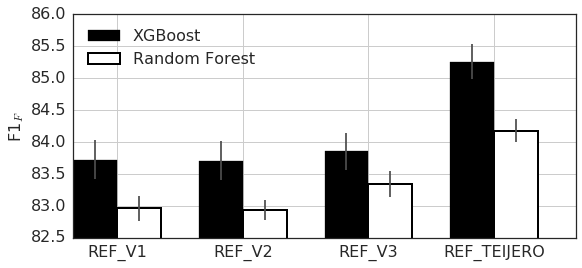

In [74]:
mpl.style.use('seaborn-white')


df_results=joblib.load('f1_by_reference_100runs.pkl')
df_results.F1=df_results.F1*100;
#display(df_results)
#current_palette_4 = sns.color_palette("hls", 4)
#sns.set_palette(current_palette_4)

n_groups = len(REFERENCES)
index = np.arange(n_groups)
#display(df_results[df_results.Classifier=='XGB'].F1)
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 1
error_config = {'ecolor': '0.3'}


#sns.set_context("paper")
#plt.style.use(['seaborn-paper', 'seaborn-white'])
#matplotlib.rc("font", family="Times New Roman")


params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (9, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}
plt.rcParams.update(params)

print()
print( df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V2'].F1.median())
print( df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V3'].F1.median())
print( df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_TEIJERO'].F1.median())
y=np.array([df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V1'].F1.median(), df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V2'].F1.median(),   df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V3'].F1.median(), df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_TEIJERO'].F1.median()])
y_err=np.array([df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V1'].F1.quantile(0.75)-df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V1'].F1.quantile(0.25), df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V2'].F1.quantile(0.75)-df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V2'].F1.quantile(0.25),  df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V3'].F1.quantile(0.75)-df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_V3'].F1.quantile(0.25), df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_TEIJERO'].F1.quantile(0.75)-df_results[df_results.Classifier=='XGB'][df_results.Reference=='REF_TEIJERO'].F1.quantile(0.25)])

rects1 = ax.bar(index, y, bar_width,
                alpha=opacity, color='black',
                yerr=y_err, error_kw=error_config,
                label='XGBoost')


y=np.array([df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V1'].F1.median(), df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V2'].F1.median(),   df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V3'].F1.median(), df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_TEIJERO'].F1.median()])
y_err=np.array([df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V1'].F1.quantile(0.75)-df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V1'].F1.quantile(0.25), df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V2'].F1.quantile(0.75)-df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V2'].F1.quantile(0.25),  df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V3'].F1.quantile(0.75)-df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_V3'].F1.quantile(0.25), df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_TEIJERO'].F1.quantile(0.75)-df_results[df_results.Classifier=='RF'][df_results.Reference=='REF_TEIJERO'].F1.quantile(0.25)])

rects2 = ax.bar(index + bar_width, y, bar_width,
                alpha=opacity, color='white', edgecolor=['black']*len(index),
                yerr=y_err, error_kw=error_config,linewidth=2.0,
                label='Random Forest')

#x.set_xlabel('Reference',fontsize=FONT_SIZE)
ax.set_ylabel('F1$_{F}$',fontsize=FONT_SIZE)
#ax.set_title('F1 score by reference and classifier')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(REFERENCES)
ax.legend(loc="upper left")
ax.set_ylim([82.5,86.0])
ax.grid()
#fig.set_facecolor('white')
#plt.rcParams['axes.facecolor']='white'
#plt.rcParams['savefig.facecolor']='white'
#plt.rcParams['savefig.force_edgecolor'] = True
#plt.rcParams['savefig.edgecolor'] = 'black'


#fig.tight_layout()
#plt.show()
plt.savefig('/notebooks/data/barchart_f1_score_by_reference.png',dpi=DPI)

In [6]:
df_results[df_results.Classifier=='XGB']

,Count,Iteration,Seed,Classifier,F1,F1 Normal,F1 AF,F1 Other,F1 Noise
0,50,1,349976,XGB,0.840,0.916,0.809,0.795,0.671
2,50,2,73517,XGB,0.837,0.914,0.805,0.791,0.658
4,50,3,116554,XGB,0.838,0.914,0.808,0.792,0.673
6,50,4,284860,XGB,0.836,0.913,0.807,0.788,0.646
8,50,5,242756,XGB,0.841,0.916,0.811,0.797,0.675
10,50,6,112174,XGB,0.840,0.916,0.812,0.794,0.667
12,50,7,425040,XGB,0.839,0.917,0.804,0.796,0.682
14,50,8,777495,XGB,0.839,0.915,0.808,0.794,0.654
16,50,9,283528,XGB,0.837,0.915,0.804,0.792,0.670
18,50,10,367006,XGB,0.841,0.914,0.817,0.791,0.690


In [7]:
df_results[df_results.Classifier=='RF']

,Count,Iteration,Seed,Classifier,F1,F1 Normal,F1 AF,F1 Other,F1 Noise
1,50,1,349976,RF,0.835,0.911,0.809,0.785,0.623
3,50,2,73517,RF,0.831,0.909,0.801,0.783,0.636
5,50,3,116554,RF,0.834,0.910,0.804,0.786,0.620
7,50,4,284860,RF,0.833,0.909,0.807,0.785,0.640
9,50,5,242756,RF,0.836,0.911,0.811,0.787,0.639
11,50,6,112174,RF,0.831,0.910,0.799,0.783,0.613
13,50,7,425040,RF,0.833,0.910,0.807,0.784,0.645
15,50,8,777495,RF,0.833,0.910,0.805,0.784,0.640
17,50,9,283528,RF,0.833,0.910,0.802,0.786,0.614
19,50,10,367006,RF,0.832,0.909,0.806,0.782,0.633


## Test by feature category

In [ ]:
feat_dha=pd.read_excel('/notebooks/data/fi_merged.xlsx')
categories=feat_dha.Category.unique()
categories=np.sort(categories)

categories

In [ ]:
df_results=pd.DataFrame(columns=['Category','Classifier','Importance','F1','F1 Normal','F1 AF','F1 Other','F1 Noise','Count'])

for category in categories:
    feat_sum_xgb= feat_dha[feat_dha.Category==category].ImportanceXGB.sum()    
    feat_sum_rf= feat_dha[feat_dha.Category==category].ImportanceRF.sum()
    
    feat_count_xgb= len(feat_dha[feat_dha.Category==category].ImportanceXGB)
    feat_count_rf= len(feat_dha[feat_dha.Category==category].ImportanceRF)

    print(category,feat_sum_xgb,feat_sum_rf)
    df_new = df[feat_dha[feat_dha.Category==category].Name]
    X=df_new.as_matrix()
    print("X: "+str(X.shape))
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_new=imp.fit_transform(X)    

    bst = XGBClassifier(**params).fit(X_new, y,verbose=50)
    [a1,a2]=test_classifier(bst,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'XGB','Importance':feat_sum_xgb, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_xgb},ignore_index=True)
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X_new, y)
    [a1,a2]=test_classifier(rf,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'RF','Importance':feat_sum_rf, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_rf},ignore_index=True)
    
joblib.dump(df_results, 'f1_by_category.pkl', compress = 1)


### Test by excluding category

In [ ]:
df_results=pd.DataFrame(columns=['Category','Classifier','Importance','F1','F1 Normal','F1 AF','F1 Other','F1 Noise','Count'])

#categories=np.append(categories,'All')
#categories=np.sort(categories)

for category in categories:
    feat_sum_xgb= feat_dha[feat_dha.Category!=category].ImportanceXGB.sum()    
    feat_sum_rf= feat_dha[feat_dha.Category!=category].ImportanceRF.sum()
    
    feat_count_xgb= len(feat_dha[feat_dha.Category!=category].ImportanceXGB)
    feat_count_rf= len(feat_dha[feat_dha.Category!=category].ImportanceRF)

    print(category,feat_sum_xgb,feat_sum_rf)
    df_new = df[feat_dha[feat_dha.Category!=category].Name]
    X=df_new.as_matrix()
    print("X: "+str(X.shape))
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_new=imp.fit_transform(X)    

    bst = XGBClassifier(**params).fit(X_new, y,verbose=50)
    [a1,a2]=test_classifier(bst,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'XGB','Importance':feat_sum_xgb, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_xgb},ignore_index=True)
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X_new, y)
    [a1,a2]=test_classifier(rf,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'RF','Importance':feat_sum_rf, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_rf},ignore_index=True)
    
joblib.dump(df_results, 'f1_by_excluding_category.pkl', compress = 1)

### Test by excluding category and meta

In [ ]:
df_results=pd.DataFrame(columns=['Category','Classifier','Importance','F1','F1 Normal','F1 AF','F1 Other','F1 Noise','Count'])

#categories=np.append(categories,'All')
#categories=np.sort(categories)

for category in categories:
    feat_sum_xgb= feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].ImportanceXGB.sum()    
    feat_sum_rf= feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].ImportanceRF.sum()
    
    feat_count_xgb= len(feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].ImportanceXGB)
    feat_count_rf= len(feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].ImportanceRF)

    print(category,feat_sum_xgb,feat_sum_rf)
    df_new = df[feat_dha[(feat_dha.Category!=category) & (feat_dha.Category!='Meta')].Name]
    X=df_new.as_matrix()
    print("X: "+str(X.shape))
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0,verbose=1)
    X_new=imp.fit_transform(X)    

    bst = XGBClassifier(**params).fit(X_new, y,verbose=50)
    [a1,a2]=test_classifier(bst,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'XGB','Importance':feat_sum_xgb, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_xgb},ignore_index=True)
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X_new, y)
    [a1,a2]=test_classifier(rf,X_new,y)
    df_results=df_results.append({'Category':category,'Classifier':'RF','Importance':feat_sum_rf, 'F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Count':feat_count_rf},ignore_index=True)
    
joblib.dump(df_results, 'f1_by_excluding_category_and_meta.pkl', compress = 1)

In [ ]:
df_results=joblib.load('f1_by_category.pkl')

#### XGBoost

In [ ]:
df_results[df_results.Classifier=='XGB']

#### RandomForest

In [ ]:
df_results[df_results.Classifier=='RF']

## Barchart: Feature importance by category

In [ ]:
n_groups = len(categories)
index = np.arange(n_groups)

fig, ax = plt.subplots()
bar_width = 0.35
opacity = 1
error_config = {'ecolor': '0.3'}



rects1 = ax.bar(index, df_results[df_results.Classifier=='XGB'].Importance, bar_width,
                alpha=opacity, color='black',
                yerr=None, error_kw=error_config,
                label='XGBoost')


#ax.set_xlabel('Category',fontsize=FONT_SIZE)
ax.set_ylabel('Importance',fontsize=FONT_SIZE)
ax.set_xticks(index+bar_width/2)
ax.set_xticklabels(categories)
#ax.legend(loc="upper left")
ax.grid()
#plt.style.use('paper')
ax.set_ylim([0,0.35])


fig.tight_layout()
#plt.show()

params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (7, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}
plt.rcParams.update(params)



plt.savefig('/notebooks/data/barchart_feature_importance_by_category.png',dpi=DPI)

## Barchart: F1 score by category and classifier

In [ ]:
n_groups = len(categories)
index = np.arange(n_groups)

fig, ax = plt.subplots()
bar_width = 0.35

opacity = 1
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, df_results[df_results.Classifier=='XGB'].F1, bar_width,
                alpha=opacity, color='black',
                yerr=None, error_kw=error_config,
                label='XGBoost')

#rects2 = ax.bar(index + bar_width, df_results[df_results.Classifier=='RF'].F1, bar_width,
#                alpha=opacity, color='b',
#                yerr=None, error_kw=error_config,
#                label='Random Forest')

#ax.set_xlabel('Category')
ax.set_ylabel('F1$_{CinC}$')
#ax.set_title('F1 on subset of features per category')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(categories)
#ax.legend(loc="upper left")
ax.set_ylim([0.3,0.85])
ax.grid()

fig.tight_layout()
#plt.show()
plt.savefig('/notebooks/data/barchart_f1_by_category.png',dpi=DPI)

## Barchart: F1 score by excluded category and classifier

In [ ]:
df_results=joblib.load('f1_by_excluding_category.pkl')
df_results

In [ ]:
fig, ax = plt.subplots()

bar_width = 0.35
opacity = 0.4
error_config = {'ecolor': '0.3'}
rc={'axes.labelsize': FONT_SIZE, 'font.size': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 'axes.titlesize': FONT_SIZE,'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)

n_groups = len(categories)


index = np.arange(n_groups)

rects1 = ax.bar(index, df_results[df_results.Classifier=='XGB'].F1, bar_width,
                alpha=opacity,color='b',
                yerr=None, error_kw=error_config,
                label='XGBoost')

rects2 = ax.bar(index + bar_width, df_results[df_results.Classifier=='RF'].F1, bar_width,
                alpha=opacity,
                yerr=None, error_kw=error_config,color='r',
                label='Random Forest')

#ax.set_xlabel('Category')
ax.set_ylabel('F1')
#ax.set_title('F1 on subset of features per category')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(categories)
ax.legend(loc="upper left")
#ax.set_ylim([0.815,0.85])
ax.set_ylim([0.81,0.85])
ax.grid()



fig.tight_layout()
plt.plot();

#plt.show()
plt.savefig('/notebooks/data/barchart_f1_by_excluded_category_and_classifier.png',dpi=100)

## Table: Number of features - F1 

In [8]:
df_results=joblib.load('top_n_feat_100runs_50-100-200-300-386.pkl')
df_results_per_count=pd.DataFrame(columns=['Count','Classifier','F1 Median','F1 IQR','Normal Median', 'Normal IQR','AF Median','AF IQR','Other Median','Other IQR','Noise Median','Noise IQR'])

groups = [50,100, 200,300,386]
#display(df_results)

for group in groups:

    f1_xgb=df_results[df_results['Count']==group][df_results.Classifier=='XGB'].F1*100
    f1_rf=df_results[df_results['Count']==group][df_results.Classifier=='RF'].F1*100
    
    normal_xgb=df_results[df_results['Count']==group][df_results.Classifier=='XGB']['F1 Normal']*100
    normal_rf=df_results[df_results['Count']==group][df_results.Classifier=='RF']['F1 Normal']*100
    
    af_xgb=df_results[df_results['Count']==group][df_results.Classifier=='XGB']['F1 AF']*100
    af_rf=df_results[df_results['Count']==group][df_results.Classifier=='RF']['F1 AF']*100
    
    other_xgb=df_results[df_results['Count']==group][df_results.Classifier=='XGB']['F1 Other']*100
    other_rf=df_results[df_results['Count']==group][df_results.Classifier=='RF']['F1 Other']*100
    
    noise_xgb=df_results[df_results['Count']==group][df_results.Classifier=='XGB']['F1 Noise']*100
    noise_rf=df_results[df_results['Count']==group][df_results.Classifier=='RF']['F1 Noise']*100    
    #display(group_values)
    
    df_results_per_count=df_results_per_count.append({'Count':group,'Classifier':'XGB','F1 Median':f1_xgb.median(),'F1 IQR':f1_xgb.quantile(0.75)-f1_xgb.quantile(0.25),'Normal Median':normal_xgb.median(),'Normal IQR':normal_xgb.quantile(0.75)-normal_xgb.quantile(0.25),'AF Median':af_xgb.median(),'AF IQR':af_xgb.quantile(0.75)-af_xgb.quantile(0.25),'Other Median':other_xgb.median(),'Other IQR':other_xgb.quantile(0.75)-other_xgb.quantile(0.25),'Noise Median':noise_xgb.median(),'Noise IQR':noise_xgb.quantile(0.75)-noise_xgb.quantile(0.25)},ignore_index=True)
    df_results_per_count=df_results_per_count.append({'Count':group,'Classifier':'RF', 'F1 Median':f1_rf.median(), 'F1 IQR':f1_rf.quantile(0.75)-f1_rf.quantile(0.25),  'Normal Median':normal_rf.median(),'Normal IQR':normal_rf.quantile(0.75)-normal_rf.quantile(0.25),'AF Median':af_rf.median(),'AF IQR':af_rf.quantile(0.75)-af_rf.quantile(0.25),'Other Median':other_rf.median(),'Other IQR':other_rf.quantile(0.75)-other_rf.quantile(0.25),'Noise Median':noise_rf.median(),'Noise IQR':noise_rf.quantile(0.75)-noise_rf.quantile(0.25)},ignore_index=True)

display(df_results_per_count.transpose())

df_results=joblib.load('top_n_feat_100runs_50-100-200-300-386.pkl')


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib

,0,1,2,3,4,5,6,7,8,9
Count,50,50,100,100,200,200,300,300,386,386
Classifier,XGB,RF,XGB,RF,XGB,RF,XGB,RF,XGB,RF
F1 Median,82.6,82.7,83.3,83.5,83.8,83.6,83.8,83.4,83.8,83.4
F1 IQR,0.3,0.2,0.3,0.2,0.3,0.2,0.3,0.2,0.3,0.2
Normal Median,90.3,90.3,90.5,90.7,90.8,90.8,90.8,90.7,90.8,90.7
Normal IQR,0.1,0.1,0.2,0.1,0.2,0.1,0.1,0.1,0.2,0.1
AF Median,82.5,82.5,83.3,83.4,84.0,83.4,84.0,83.1,84.0,83.1
AF IQR,0.6,0.4,0.6,0.4,0.6,0.3,0.5,0.4,0.6,0.4
Other Median,75.1,75.3,75.9,76.5,76.6,76.5,76.8,76.3,76.7,76.3
Other IQR,0.4,0.3,0.4,0.3,0.4,0.2,0.4,0.3,0.5,0.3


In [9]:
df_results_per_count=pd.DataFrame(columns=['Count','XGB','RF'])

for i in [50,100,200,300,386]:
    xgb=df_results[df_results.Classifier=='XGB'][df_results.Count==i].F1*100
    #display(xgb_50.values)
    rf=df_results[df_results.Classifier=='RF'][df_results.Count==i].F1*100
    for j in range(1,len(xgb.values)):
        xgb_j=xgb.iloc[j]
        rf_j=rf.iloc[j]
        df_results_per_count=df_results_per_count.append({'Count':i,'XGB':xgb_j,'RF':rf_j},ignore_index=True)
    
display(df_results_per_count)    

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Count,XGB,RF
0,50.0,82.6,82.6
1,50.0,82.4,83.0
2,50.0,82.9,82.7
3,50.0,82.5,82.7
4,50.0,82.3,82.8
5,50.0,82.4,82.7
6,50.0,82.7,83.0
7,50.0,82.7,82.8
8,50.0,82.5,82.6
9,50.0,82.5,82.8


## Revison: Boxplot: Number of features - F1 score

/opt/conda/lib/python3.5/site-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


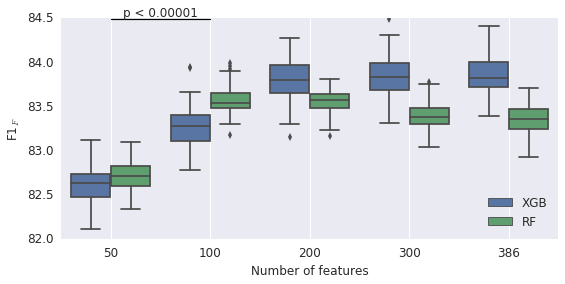

In [16]:
#display(df)
FONT_SIZE=12
params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (8, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}
plt.rcParams.update(params)



import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dd=pd.melt(df_results_per_count,id_vars=['Count'],value_vars=['XGB','RF'],var_name='Classifier')

dd=dd.rename(index=str, columns={"value": "F1$_{F}$"})
dd=dd.rename(index=str, columns={"Count": "Number of features"})
    
dd['Number of features'] =dd['Number of features'] .astype(int)
#display(dd)

sns.boxplot(x='Number of features',y='F1$_{F}$',data=dd,hue='Classifier')

plt.legend(loc='lower right')

ax=plt.gca()

x1, x2 = 0, 1 
y, h, col = df_results_per_count.XGB.max()+0.001, 0.0010, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.2, c=col)
ax.text((x1+x2)*.5, y+h, "p < 0.00001", ha='center', va='bottom')
ax.grid()
fig = ax.get_figure()

plt.tight_layout()
plt.show()
#plt.savefig('/notebooks/data/boxplot_f1_score_by_number_of_features.png',dpi=DPI)



In [32]:
df_results_per_count

,Count,XGB,RF
0,50.0,82.6,82.6
1,50.0,82.4,83.0
2,50.0,82.9,82.7
3,50.0,82.5,82.7
4,50.0,82.3,82.8
5,50.0,82.4,82.7
6,50.0,82.7,83.0
7,50.0,82.7,82.8
8,50.0,82.5,82.6
9,50.0,82.5,82.8


## Plot: Number of features - F1 score

AttributeError: 'DataFrame' object has no attribute 'Classifier'

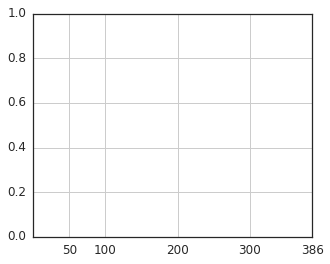

In [60]:

plt.figure(0)
ax = plt.axes()

x_ticks=[50,100, 200,300,386]
ax.set_xticklabels([i for i in x_ticks])
#ax.bar(x_ticks,df_results_per_count[df_results_per_count.Classifier=='XGB']['F1 Median'])
ax.set_xticks(x_ticks)
ax.set_xticklabels([i for i in x_ticks])
    
    
plt.grid()
params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (5, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}

plt.rcParams.update(params)
plt.plot(df_results_per_count[df_results_per_count.Classifier=='XGB']['F1 Median'].reset_index(drop=True)
, color='cornflowerblue',label='XGBoost')
plt.legend(loc='lower right')
plt.ylabel('5-fold CV F1$_{CinC}$ score')
plt.plot(df_results_per_count[df_results_per_count.Classifier=='RF']['F1 Median'].reset_index(drop=True)
, color='red',label='Random Forest')



plt.legend(loc='lower right')
plt.ylabel('F1$_{CinC}$ score')
plt.xlabel('Number of features')
plt.tight_layout()

plt.savefig('linechart_n_feat_vs_f1.png',dpi=DPI)

plt.show()



array([0.265, 0.301, 0.321, 0.308, 0.278])

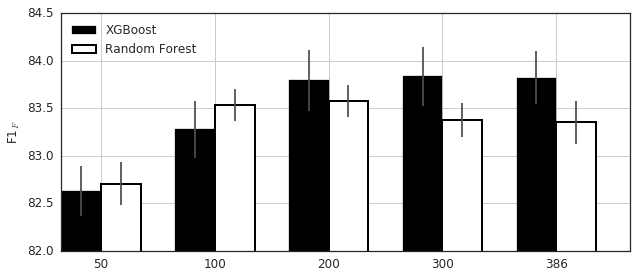

In [57]:
mpl.style.use('seaborn-white')


df_results=joblib.load('f1_by_reference_100runs.pkl')
#display(df_results)
#current_palette_4 = sns.color_palette("hls", 4)
#sns.set_palette(current_palette_4)


groups=['50','100','200','300','386']

n_groups = len(groups)
index = np.arange(n_groups)
#display(df_results[df_results.Classifier=='XGB'].F1)
fig, ax = plt.subplots()
bar_width = 0.35
opacity = 1
error_config = {'ecolor': '0.3'}


#sns.set_context("paper")
#plt.style.use(['seaborn-paper', 'seaborn-white'])
#matplotlib.rc("font", family="Times New Roman")


params = {'legend.fontsize': FONT_SIZE,
         'axes.labelsize': FONT_SIZE,
         'axes.titlesize':FONT_SIZE,
         'figure.figsize': (9, 4),
         'xtick.labelsize':FONT_SIZE,
         'ytick.labelsize':FONT_SIZE}
plt.rcParams.update(params)


#print( df_results_per_count[df_results_per_count.Count==50].XGB.median())
#print( df_results_per_count[df_results_per_count.Count==100].XGB.median())
#print( df_results_per_count[df_results_per_count.Count==200].XGB.median())
#print( df_results_per_count[df_results_per_count.Count==300].XGB.median())
#print( df_results_per_count[df_results_per_count.Count==386].XGB.median())

y=np.array([df_results_per_count[df_results_per_count.Count==50].XGB.median(), df_results_per_count[df_results_per_count.Count==100].XGB.median(),   df_results_per_count[df_results_per_count.Count==200].XGB.median(),df_results_per_count[df_results_per_count.Count==300].XGB.median(),df_results_per_count[df_results_per_count.Count==386].XGB.median()])
y_err=np.array([df_results_per_count[df_results_per_count.Count==50].XGB.quantile(0.75)-df_results_per_count[df_results_per_count.Count==50].XGB.quantile(0.25),df_results_per_count[df_results_per_count.Count==100].XGB.quantile(0.75)-df_results_per_count[df_results_per_count.Count==100].XGB.quantile(0.25), df_results_per_count[df_results_per_count.Count==200].XGB.quantile(0.75)-df_results_per_count[df_results_per_count.Count==200].XGB.quantile(0.25),df_results_per_count[df_results_per_count.Count==300].XGB.quantile(0.75)-df_results_per_count[df_results_per_count.Count==300].XGB.quantile(0.25),df_results_per_count[df_results_per_count.Count==386].XGB.quantile(0.75)-df_results_per_count[df_results_per_count.Count==386].XGB.quantile(0.25)])


display(y_err)
rects1 = ax.bar(index, y, bar_width,
                alpha=opacity, color='black',
                yerr=y_err, error_kw=error_config,
                label='XGBoost')

y=np.array([df_results_per_count[df_results_per_count.Count==50].RF.median(), df_results_per_count[df_results_per_count.Count==100].RF.median(),   df_results_per_count[df_results_per_count.Count==200].RF.median(),df_results_per_count[df_results_per_count.Count==300].RF.median(),df_results_per_count[df_results_per_count.Count==386].RF.median()])
y_err=np.array([df_results_per_count[df_results_per_count.Count==50].RF.quantile(0.75)-df_results_per_count[df_results_per_count.Count==50].RF.quantile(0.25),df_results_per_count[df_results_per_count.Count==100].RF.quantile(0.75)-df_results_per_count[df_results_per_count.Count==100].RF.quantile(0.25), df_results_per_count[df_results_per_count.Count==200].RF.quantile(0.75)-df_results_per_count[df_results_per_count.Count==200].RF.quantile(0.25),df_results_per_count[df_results_per_count.Count==300].RF.quantile(0.75)-df_results_per_count[df_results_per_count.Count==300].RF.quantile(0.25),df_results_per_count[df_results_per_count.Count==386].RF.quantile(0.75)-df_results_per_count[df_results_per_count.Count==386].RF.quantile(0.25)])

rects2 = ax.bar(index + bar_width, y, bar_width,
                alpha=opacity, color='white', edgecolor=['black']*len(index),
                yerr=y_err, error_kw=error_config,linewidth=2.0,
                label='Random Forest')

#x.set_xlabel('Reference',fontsize=FONT_SIZE)
ax.set_ylabel('F1$_{F}$',fontsize=FONT_SIZE)
#ax.set_title('F1 score by reference and classifier')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(groups)
ax.legend(loc="upper left")
ax.set_ylim([82.0,84.5])
ax.grid()
#fig.set_facecolor('white')
#plt.rcParams['axes.facecolor']='white'
#plt.rcParams['savefig.facecolor']='white'
#plt.rcParams['savefig.force_edgecolor'] = True
#plt.rcParams['savefig.edgecolor'] = 'black'


fig.tight_layout()
#plt.show()
plt.savefig('/notebooks/data/barchart_f1_score_by_count.png',dpi=DPI)

In [ ]:
df_results[df_results.Classifier=='XGB']['F1 Normal']

/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


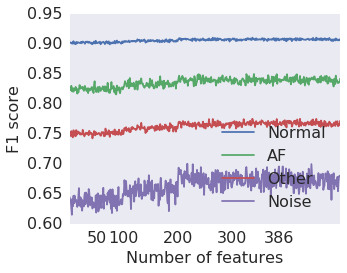

In [71]:
plt.figure(1)
ax = plt.axes()
ax.set_xticks([50,100, 200,300,386])
plt.grid()
plt.legend(loc='lower right')
plt.ylabel('5-fold CV F1$_{CinC}$ score')
plt.plot(df_results[df_results.Classifier=='XGB']['F1 Normal'].reset_index(drop=True), label='Normal')
plt.plot(df_results[df_results.Classifier=='XGB']['F1 AF'].reset_index(drop=True), label='AF')
plt.plot(df_results[df_results.Classifier=='XGB']['F1 Other'].reset_index(drop=True), label='Other')
plt.plot(df_results[df_results.Classifier=='XGB']['F1 Noise'].reset_index(drop=True), label='Noise')
plt.legend(loc='lower right')
plt.ylabel('F1 score')
plt.xlabel('Number of features')
plt.rcParams.update(params)
plt.tight_layout()
#plt.show()

plt.savefig('linechart_n_feat_vs_f1_per_class.png',dpi=DPI)

#plt.show()

# Test for statistical difference on N runs with random seed

Tests the classifier N times using a pseudo-random seed, based on current microsecond

In [ ]:
N=100 #number of runs

df_results=pd.DataFrame(columns=['Iteration','Seed','Classifier','F1','F1 Normal','F1 AF','F1 Other','F1 Noise','Training Time'])

for i in range(1,N+1):
    print('\nIteration',i,'Seed',seed)
    seed = datetime.datetime.now().microsecond
    cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=seed)
    
    tic('Train XGB')
    bst = XGBClassifier(**params).fit(X, y,verbose=50)
    train_xgb_time=toc()
    a1,a2=test_classifier(bst,X,y)
    df_results=df_results.append({'Iteration': i,'Seed':seed,'Classifier':'XGB','F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Training Time':train_xgb_time},ignore_index=True)

    tic('Train RF')
    rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X, y)
    train_rf_time=toc()
    a1,a2=test_classifier(rf,X,y)
    df_results=df_results.append({'Iteration': i,'Seed':seed,'Classifier':'RF','F1':a1,'F1 Normal':a2[1],'F1 AF':a2[0],'F1 Other':a2[2],'F1 Noise':a2[3],'Training Time':train_rf_time},ignore_index=True)

    
    
    
    
    
joblib.dump(df_results, 'f1_100_runs.pkl', compress = 1)

In [ ]:
df_results=joblib.load('top_n_feat_100runs.pkl')

### Boxplot: XGB vs. RF

XGB: 0.839 +/- 0.002, RF 0.834 +/- 0.001
p-Value: 0.00000000000000000000000000000000000000000000000006
p-Value: 0.00000000000000000389655984509590921748877339445397


/opt/conda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


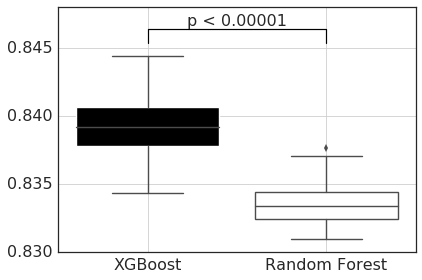

In [162]:
df_results=joblib.load('f1_100_runs.pkl')
mpl.style.use('seaborn-white')


print("XGB: %.3f +/- %.3f, RF %.3f +/- %.3f"%(df_results[df_results.Classifier=='XGB'].F1.mean(),df_results[df_results.Classifier=='XGB'].F1.std(),df_results[df_results.Classifier=='RF'].F1.mean(),df_results[df_results.Classifier=='RF'].F1.std()))
statistic,p_value=stats.ttest_rel(df_results[df_results.Classifier=='XGB'].F1,df_results[df_results.Classifier=='RF'].F1)
print('p-Value: %.50f' % (float(p_value)))
statistic,p_value=stats.wilcoxon(df_results[df_results.Classifier=='XGB'].F1,df_results[df_results.Classifier=='RF'].F1)
print('p-Value: %.50f' % (float(p_value)))
                                                        
df_f1_xgb=df_results[df_results.Classifier=='XGB'].F1.reset_index(drop=True)
df_f1_rf=df_results[df_results.Classifier=='RF'].F1.reset_index(drop=True)
df_f1=pd.concat([df_f1_xgb,df_f1_rf],axis=1)

df_f1.columns = ['XGBoost', 'Random Forest']
#display(df_f1)

#sns.set_style("whitegrid")
sns.set_context("paper")
plt.style.use(['seaborn-paper', 'seaborn-white'])
#matplotlib.rc("font", family="Times New Roman")

rc={'axes.labelsize': FONT_SIZE, 'font.size': FONT_SIZE, 'legend.fontsize': FONT_SIZE, 'axes.titlesize': FONT_SIZE,'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)

ax = sns.boxplot(data=df_f1)
  
box = ax.artists[1]
box.set_facecolor('white')

box = ax.artists[0]
box.set_facecolor('black')
box.set_edgecolor('white')



x1, x2 = 0, 1 
y, h, col = df_f1_xgb.max()+0.001, 0.0010, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.2, c=col)
ax.text((x1+x2)*.5, y+h, "p < 0.00001", ha='center', va='bottom')
ax.grid()
fig = ax.get_figure()



fig.savefig('boxplot_xgb_vs_rf.png', format='png', dpi=DPI)

## Feature importance table

In [ ]:
def fi_table(clf,df):
    fi=pd.DataFrame(clf.feature_importances_)
    #display(fi)
    fi.columns = ['Importance']
    cols=pd.DataFrame(list(df.columns))
    cols.columns = ['Feature']
    result = pd.concat( [fi, cols], axis=1)
    fi_sorted=result.sort_values(by='Importance', ascending=False)
    return fi_sorted

fi_sorted=fi_table(rf,df)
fi_sorted.to_excel('/notebooks/data/fi_rf.xlsx')

## XGBoost

### Train

In [6]:
tic('Train XGB')
print(params)
bst = XGBClassifier(**params).fit(X, y,verbose=50)
joblib.dump(bst, 'xgboost_joblib.pkl', compress = 1)
a=toc()
print(a)

Tic: Train XGB
{'nthread': 4, 'gamma': 0.25, 'colsample_bylevel': 1, 'missing': None, 'subsample': 0.9316857241778637, 'colsample_bytree': 0.8195883168402892, 'objective': 'multi:softmax', 'silent': 0, 'reg_alpha': 0, 'learning_rate': 0.260465157489139, 'max_delta_step': 0, 'scale_pos_weight': 1, 'max_depth': 7, 'min_child_weight': 0.9, 'n_estimators': 110}
Elapsed time: 43.391177 seconds.

43.3911771774292


### Test

In [5]:
tic('Test XGB')
test_classifier(bst,X,y)
toc()

In [ ]:
tic('Test XGB prediction runtime')
y=bst.predict(X)
toc()

## Random Forest

### Train

In [7]:
tic('Train RF')
rf = RandomForestClassifier(n_jobs=-1, random_state=seed,n_estimators=RF_N_TREES).fit(X, y)
joblib.dump(rf,'rf_joblib.pkl', compress = 1)
toc()

Tic: Train RF
Elapsed time: 55.179306 seconds.



55.17930626869202

### Test

In [ ]:
tic('Test RF')
test_classifier(rf, X,y)
toc()

In [ ]:
tic('Test RF prediction runtime')
y=rf.predict(X)
toc()

# Cross validated predictions of model

In [8]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(bst, X, y,cv=cv)
answers = pd.concat([rec,pd.DataFrame(y_pred)], axis=1)
answers.to_csv('y_5xCV_xgb.txt',index=None,header=None)

y_pred = cross_val_predict(rf, X, y,cv=cv)
answers = pd.concat([rec,pd.DataFrame(y_pred)], axis=1)
answers.to_csv('y_5xCV_rf.txt',index=None,header=None)

# Neural Network: Train and test

In [ ]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(alpha=0.01, random_state=seed)

nn=nn.fit(X, y)    
print(nn)
test_classifier(nn,X,y)

In [ ]:
plt.style.available

#### Rename categories

In [ ]:
df_results=joblib.load('f1_by_category.pkl')
df_results=df_results.replace('Average beat','Average')
df_results=df_results.replace('QRS detection','QRS')
joblib.dump(df_results, 'f1_by_category.pkl', compress = 1)
df_results